# MNIST classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

## Fetching dataset

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']

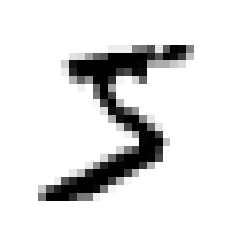

In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary,interpolation="nearest")
plt.axis('off')
plt.show()

In [5]:
y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier
Simplyfing the problem - now I want to to recognize only one digit - 5.
Below there are target vectors for this task

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
y_train_5

array([ True, False, False, ...,  True, False, False])

Creating a SGDC Classifier and trainign it on whole train set

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

## Measuring accuracy using Cross-Validation

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

### Not-5 classifier
This example shows that accuracy is not perfect classifier. When we always predict that a number is not 5 it will have about 90% accuracy becouse only about 10% of the numbers in dataset are fives - so when we always say the number is not 5, we will be right in 90% of times! 

In [11]:
from sklearn.base import BaseEstimator

class never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [12]:
never_5_clf = never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix
Much better way to evaluate classifier's performance is to look at the confusion matrix. The general idea is to see how many times e.g. number 3 was confused with number 5 (5th row and 3th column of this matrix).

But to compute this matrix we have to have a set of predictions, so they can be compared to the actual targets.

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in prediciton matrix represents an actual class, while each column a predicted class.
The first row of the matrix considers non-5 images (negative class): 53892 was correctly classified as non-5s (true negatives) and 687 were wrongly classified as 5s (false positives). The second row considers the images of 5s (positive class): 1891 was wrongly classified as non-5s (false negatives) and 3530 were correctly classifies as 5s (true positives).

There is also more consistent accuracy measuring method. - precission of the classifier.

##### Precision = TP/(TP + FP)

It is not very useful on its own (becouse the model could do only one correct prediciton and has 1/1 = 100% precision), so it's often used with recall (also called sensitivity or true positive rate - TPR).

##### Recall = TP/(TP + FN) 

In [15]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [16]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

A single metric that combines precision and recall is called the F1 score and it's their harmonic mean. The hramonic mean gives a high value only if both values are high.

In [17]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

F1 score favors clasifiers that have similar precision and recall, but that is not always what we want.
Increasing precission reduces recall and vice versa - precision/recall tradeoff.
We can change the tradeoff changing the threshold.

In [18]:
y_scores = sgd_clf.decision_function([some_digit])
threshold = 0 # used be SGDClassifier
y_some_digit_pred_0 = (y_scores > threshold)
threshold = 8000
y_some_digit_pred_8000 = (y_scores > threshold)
print("threshold 0:", y_some_digit_pred_0)
print("threshold 8000:", y_some_digit_pred_8000)


threshold 0: [ True]
threshold 8000: [False]


##### How to decide which threshold to use?
First we need to get scores of all instances in the training set using - cross_val_predict(), but now we specify that we want decision function to be returned.
Then we can compute precision and recall for all possible threshold.

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function')

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Now using this scores we can plot a precision and recall as a function of a thresholf value

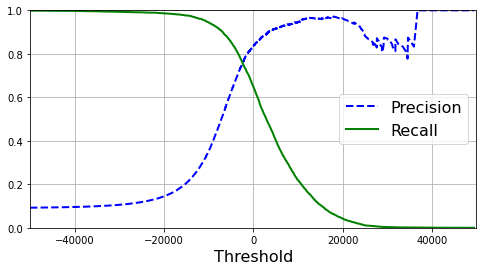

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
# plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
# plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:"
# plt.plot([threshold_90_precision], [0.9], "ro")
# plt.plot([threshold_90_precision], [recall_90_precision], "ro")
# save_fig("precision_recall_vs_threshold_plot")
plt.show()

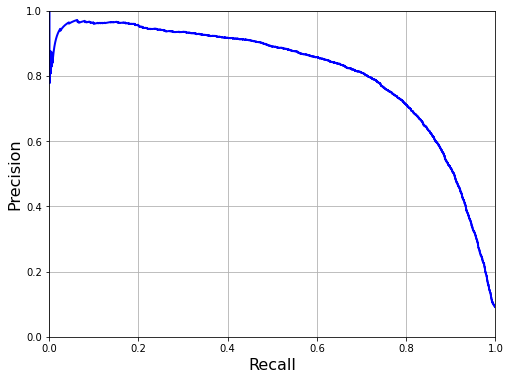

In [22]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
# plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
# plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
# plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

##### ROC Curve
Itplots the true positive rate against the false positive rate. (ROC plots recall against 1-recall)

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

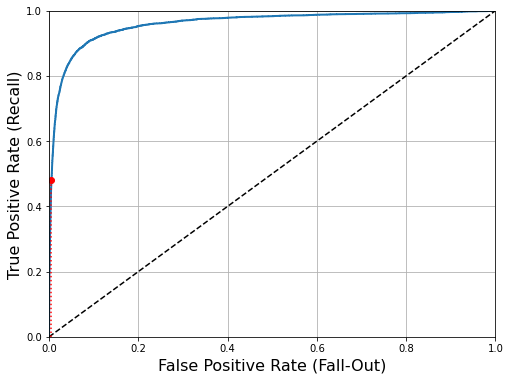

In [26]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

One way to compare classifiers is to measure the Area Under Curve - AUC. PErfect classifier has the AUC equal to 1, completely random classifier equal to 0.5 (dotted line at the above plot)

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Precision/Recall curve should be used when the positive class is rare or when we care more about the false positives than false negatives.
The ROC curve otherwise.

In above example we can think that the ROC curve is pretty good, but it is mostly becouse there are few positives (5s) compared to negatvies (non-5s). In contrast the PR curve makes it clear that the classifier has a room for improvement (the curve could be closer to the top right corner)


### Comparing Random Forest Classifier ROC and AUC to the SGD Classifier's ones
The random forest has no decision function, but instead there is a predict proba.
It's an array containig a row per instance and a column per class, each containing the probablity that this instance belongs to that class.

In [29]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')


In [30]:
y_scores_forest = y_probas_forest[:, 1] # score is for me = proba of positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

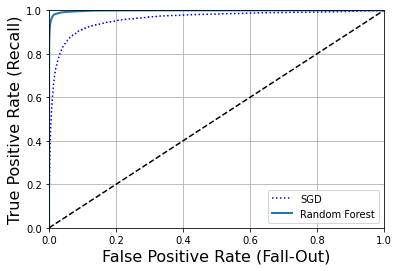

In [33]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [36]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

0.9905083315756169

In [37]:
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [38]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

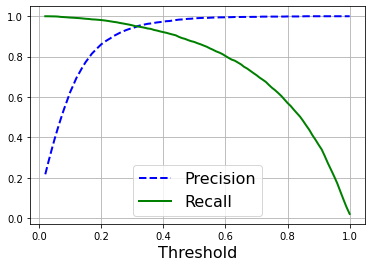

In [48]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_forest)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="lower center", fontsize=16)
plt.xlabel("Threshold", fontsize=16)
plt.grid(True)
# plt.axis([-50000, 50000, 0, 1])

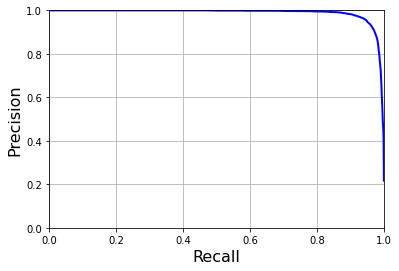

In [49]:
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.grid(True)